<a href="https://colab.research.google.com/github/HanifFaishalH/Kuis2_KlasifikasiJenisBatik/blob/main/Kuis2_Batik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Preprocessing Data Batik

Image enhancement → contras/brightness correction, noise removal, glare removal, etc.

In [2]:
import cv2
import os
import numpy as np
from tqdm import tqdm

input_dir = '/content/drive/MyDrive/batik_dataset/batik-augmentasi'
output_dir = '/content/drive/MyDrive/batik_dataset/batik-enhanced'
os.makedirs(output_dir, exist_ok=True)

def enhance_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    # 1. Contrast enhancement (CLAHE)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # 2. Brightness normalization
    hsv = cv2.cvtColor(enhanced, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.equalizeHist(v)
    hsv_enhanced = cv2.merge((h, s, v))
    enhanced = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2BGR)

    # 3. Noise removal (bilateral)
    denoised = cv2.bilateralFilter(enhanced, d=9, sigmaColor=75, sigmaSpace=75)

    # 4. Glare removal
    gray = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    glare_removed = cv2.inpaint(denoised, mask, 3, cv2.INPAINT_TELEA)

    return glare_removed

print("✨ Melakukan enhancement gambar...")
for filename in tqdm(os.listdir(input_dir)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)
        enhanced = enhance_image(input_path)
        if enhanced is not None:
            cv2.imwrite(output_path, enhanced)
print("✅ Enhancement selesai! Hasil disimpan di:", output_dir)

✨ Melakukan enhancement gambar...


100%|██████████| 900/900 [01:37<00:00,  9.27it/s]

✅ Enhancement selesai! Hasil disimpan di: /content/drive/MyDrive/batik_dataset/batik-enhanced


# 2. Ekstraksi Fitur

Metode ekstraksi fitur yang digunakan terdiri dari tiga jenis, yaitu GLCM, LBP, dan HSV Histogram.
1. GLCM (Gray Level Co-occurrence Matrix): Seberapa sering dua piksel dengan keabuan tertentu muncul bersebelahan dari arah tertentu (horizontal, vertikal, atau diagonal). Berguna untuk membedakan pola manual dan cetakan (tulis dan cap).
2. LBP (Local Binary Pattern): Melihat tiap piksel dan membandingkannya dengan tetangga (8 tetangga piksel). Berguna untuk membedakan pola acak dan berulang.
3. HSV Histogram: Batik memiliki warna yang khas. Batik cap punya warna yang lebih seragam dan kontras, sedangkan Batik tulis punya variasi warna. Berguna untuk menangkap gaya pewarnaan dan intensitas warna

In [3]:
import cv2
import os
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern

# === Path input dan output ===
label_csv = '/content/drive/MyDrive/batik_dataset/batik300_labels.csv'
output_csv = '/content/drive/MyDrive/batik_dataset/batik_motif_features.csv'

# === Fungsi ekstraksi fitur ===
def extract_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # --- GLCM ---
    glcm = graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast').mean()
    dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy = graycoprops(glcm, 'energy').mean()
    correlation = graycoprops(glcm, 'correlation').mean()

    # --- LBP ---
    lbp = local_binary_pattern(gray, 8, 1, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 59))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    lbp_mean = hist.mean()
    lbp_std = hist.std()

    # --- HSV ---
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv], [0], None, [8], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [8], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [8], [0, 256])
    color_features = np.concatenate([hist_h, hist_s, hist_v]).flatten()
    color_features /= (color_features.sum() + 1e-7)

    return np.hstack([
        [contrast, dissimilarity, homogeneity, energy, correlation],
        [lbp_mean, lbp_std],
        color_features
    ])

# === Ekstraksi fitur dari semua gambar ===
data = []
filenames = []

print("🚀 Mengekstraksi fitur dari semua citra di folder...")

for file in tqdm(os.listdir(input_dir)):
    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(input_dir, file)
        feats = extract_features(img_path)
        if feats is not None:
            data.append(feats)
            filenames.append(file)



🚀 Mengekstraksi fitur dari semua citra di folder...


100%|██████████| 900/900 [02:01<00:00,  7.44it/s]


## Mengekstraksi Semua Fitur dari Setiap Gambar dalam Folder Motif.

In [4]:
if len(data) == 0:
    print("❌ Tidak ada citra valid di folder ini!")
else:
    # === Buat DataFrame fitur ===
    columns = [
        'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation',
        'lbp_mean', 'lbp_std'
    ] + [f'color_{i+1}' for i in range(24)]  # 8 H + 8 S + 8 V

    features_df = pd.DataFrame(data, columns=columns)
    features_df['filename'] = filenames

    # === Baca file label ===
    labels_df = pd.read_csv(label_csv)

    # === Buat kolom prefix agar bisa dihubungkan ===
    features_df['prefix'] = features_df['filename'].apply(
        lambda x: re.match(r'(B\d+_\d+)', x).group(1) if re.match(r'(B\d+_\d+)', x) else None
    )
    labels_df['prefix'] = labels_df['filename'].apply(
        lambda x: re.match(r'(B\d+_\d+)', x).group(1) if re.match(r'(B\d+_\d+)', x) else None
    )

    # === Tambahkan kolom motif_name & region jika belum ada ===
    if 'motif_name' not in labels_df.columns or 'region' not in labels_df.columns:
        motif_mapping = {
            1: ('Parang', 'Yogyakarta'),
            2: ('Kawung', 'Yogyakarta'),
            3: ('Mega Mendung', 'Cirebon'),
            4: ('Ceplok', 'Solo'),
            5: ('Truntum', 'Solo'),
            6: ('Lereng', 'Pekalongan'),
            7: ('Lasem', 'Lasem'),
            8: ('Sekar Jagad', 'Solo'),
            9: ('Tambal', 'Yogyakarta'),
            10: ('Nitik', 'Yogyakarta'),
            11: ('Pamiluto', 'Pekalongan'),
            12: ('Sido Mukti', 'Solo'),
            13: ('Sido Luhur', 'Yogyakarta'),
            14: ('Sekar Arum', 'Pekalongan'),
            15: ('Grompol', 'Solo'),
            16: ('Wahyu Tumurun', 'Yogyakarta'),
            17: ('Cuwiri', 'Yogyakarta'),
            18: ('Gurda', 'Surakarta'),
            19: ('Singa Barong', 'Cirebon'),
            20: ('Gringsing', 'Bali'),
            21: ('Sida Asih', 'Yogyakarta'),
            22: ('Klithik', 'Solo'),
            23: ('Sido Drajat', 'Yogyakarta'),
            24: ('Udan Liris', 'Yogyakarta'),
            25: ('Sekar Kencana', 'Solo'),
            26: ('Sekar Melati', 'Pekalongan'),
            27: ('Bunga Teratai', 'Pekalongan'),
            28: ('Wahyu Nugraha', 'Solo'),
            29: ('Jlamprang', 'Pekalongan'),
            30: ('Sidoluhur', 'Yogyakarta'),
            31: ('Sida Mukti', 'Yogyakarta'),
            32: ('Sido Mulyo', 'Solo'),
            33: ('Merak Ngibing', 'Cirebon'),
            34: ('Lung-lungan', 'Yogyakarta'),
            35: ('Gurdo', 'Yogyakarta'),
            36: ('Alas-alasan', 'Banyumas'),
            37: ('Kembang Kantil', 'Solo'),
            38: ('Kembang Tanjung', 'Pekalongan'),
            39: ('Sekar Jagad', 'Yogyakarta'),
            40: ('Pisan Bali', 'Bali'),
            41: ('Sekar Sari', 'Solo'),
            42: ('Sido Mulyo', 'Yogyakarta'),
            43: ('Grompol', 'Solo'),
            44: ('Sidomukti', 'Yogyakarta'),
            45: ('Tambal', 'Yogyakarta'),
            46: ('Parang Klitik', 'Yogyakarta'),
            47: ('Sekar Mayang', 'Solo'),
            48: ('Sido Luhur', 'Yogyakarta'),
            49: ('Truntum', 'Solo'),
            50: ('Mega Mendung', 'Cirebon')
        }
        labels_df['motif_num'] = labels_df['motif_id'].apply(lambda x: int(x[1:]) if isinstance(x, str) and x.startswith('B') else None)
        labels_df['motif_name'] = labels_df['motif_num'].map(lambda x: motif_mapping.get(x, ('Unknown','Unknown'))[0])
        labels_df['region'] = labels_df['motif_num'].map(lambda x: motif_mapping.get(x, ('Unknown','Unknown'))[1])

    # === Merge label ke fitur ===
    merged_df = features_df.merge(
        labels_df[['prefix', 'motif_id', 'motif_name', 'region']],
        on='prefix',
        how='left'
    )

    merged_df.drop(columns=['prefix'], inplace=True)
    merged_df.to_csv(output_csv, index=False)

    print(f"✅ Ekstraksi dan labeling selesai!")
    print(f"📁 File disimpan di: {output_csv}")
    print("Total citra:", len(merged_df))
    print(merged_df[['filename', 'motif_id', 'motif_name', 'region']].head(10))

✅ Ekstraksi dan labeling selesai!
📁 File disimpan di: /content/drive/MyDrive/batik_dataset/batik_motif_features.csv
Total citra: 900
           filename motif_id motif_name      region
0  B10_1_aug_01.jpg      B10      Nitik  Yogyakarta
1  B10_1_aug_02.jpg      B10      Nitik  Yogyakarta
2  B10_1_aug_03.jpg      B10      Nitik  Yogyakarta
3  B10_2_aug_01.jpg      B10      Nitik  Yogyakarta
4  B10_2_aug_02.jpg      B10      Nitik  Yogyakarta
5  B10_2_aug_03.jpg      B10      Nitik  Yogyakarta
6  B10_3_aug_01.jpg      B10      Nitik  Yogyakarta
7  B10_3_aug_02.jpg      B10      Nitik  Yogyakarta
8  B10_3_aug_03.jpg      B10      Nitik  Yogyakarta
9  B10_4_aug_01.jpg      B10      Nitik  Yogyakarta


## Reduksi Dimensi dengan PCA

🔍 Data awal:
    contrast  dissimilarity  homogeneity    energy  correlation  lbp_mean  \
0  20.134363       3.143752     0.316555  0.042941     0.961647  0.017241   
1  45.720220       4.761878     0.236101  0.034125     0.935655  0.017241   
2  19.911997       3.128265     0.318115  0.042753     0.962160  0.017241   
3  46.617741       4.804822     0.233524  0.033588     0.938806  0.017241   
4  46.635149       4.805071     0.233776  0.033584     0.938799  0.017241   

    lbp_std   color_1  color_2  color_3  ...  color_19  color_20  color_21  \
0  0.059941  0.330416      0.0      0.0  ...  0.024467  0.187508  0.114726   
1  0.059772  0.329863      0.0      0.0  ...  0.028632  0.185238  0.105699   
2  0.059998  0.330390      0.0      0.0  ...  0.024804  0.185930  0.116093   
3  0.060215  0.328854      0.0      0.0  ...  0.026622  0.177308  0.112263   
4  0.060199  0.328972      0.0      0.0  ...  0.026597  0.177484  0.112148   

   color_22  color_23  color_24          filename  moti

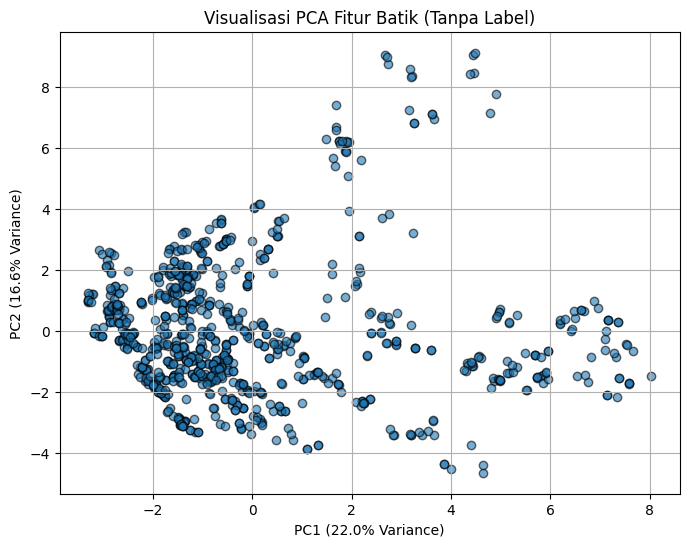

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Path file CSV fitur
csv_path = '/content/drive/MyDrive/batik_dataset/batik_motif_features.csv'

# Baca dataset
df = pd.read_csv(csv_path)
print("🔍 Data awal:")
print(df.head())
print(df.isnull().sum())

# Pisahkan kolom non-fitur (misal 'filename') jika ada
non_feature_cols = [col for col in df.columns if not col.startswith(('contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'lbp_', 'color_'))]
print(f"🧩 Kolom non-fitur dihapus: {non_feature_cols}")

X = df.drop(columns=non_feature_cols, errors='ignore')


# Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"✅ Data berhasil distandarisasi. Ukuran: {X_scaled.shape}")


# PCA (Reduksi Dimensi)
pca = PCA(n_components=2)  # ambil 2 komponen utama untuk visualisasi
X_pca = pca.fit_transform(X_scaled)

print("🎯 Variance ratio tiap komponen:", pca.explained_variance_ratio_)
print(f"🔹 Total variance yang dijelaskan: {sum(pca.explained_variance_ratio_):.2f}")


# Visualisasi PCA 2D
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, edgecolor='k')
plt.title('Visualisasi PCA Fitur Batik (Tanpa Label)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% Variance)')
plt.grid(True)
plt.show()
